# 부족한 정보를 검색하여 Context 보강

**절차**

1. 전통적인 RAG 를 수행
2. 검색된 문서에 답변에 필요한 정보가 부족한 경우 -> “웹 검색”을 위한 쿼리 재작성
3. “웹 검색” 으로 보충된 정보로 답변 도출 시도
4. 새로운 답변으로 관련성 체크 후 재조정/종료 진행

![](image/retrieve-and-search.jpeg)

In [2]:
# api key
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("my-LangGraph-with-search")

LangSmith 추적을 시작합니다.
[프로젝트명]
my-LangGraph-with-search


In [12]:
from rag.pdf import PDFRetrievalChain

pdf = PDFRetrievalChain(["../pdf/gun01.pdf"]).create_chain()
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

## GraphState

각 노드에서 다음 노드로 전달되는 상태를 저장합니다.

In [7]:
from typing import TypedDict


# GraphState 상태를 저장하는 용도로 사용합니다.
class GraphState(TypedDict):
    question: str  # 질문
    context: str  # 문서의 검색 결과
    answer: str  # 답변
    relevance: str  # 답변의 문서에 대한 관련성

## 노드와 엣지

우리는 agentic RAG 그래프를 다음과 같이 구성할 수 있습니다:

- 상태는 메시지의 집합입니다
- 각 노드는 상태를 업데이트(추가)합니다
- 조건부 엣지는 다음에 방문할 노드를 결정합니다

![](https://teddylee777.github.io/images/2024-03-06-langgraph-agentic-rag/nodes-and-edges.png)


In [13]:
from langchain_upstage import UpstageGroundednessCheck
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools.tavily_search import TavilySearchResults
from rag.utils import format_docs, format_searched_docs

# 업스테이지 문서 관련성 체크 기능을 설정합니다. https://upstage.ai
upstage_ground_checker = UpstageGroundednessCheck()


# 문서에서 검색하여 관련성 있는 문서를 찾습니다.
def retrieve_document(state: GraphState) -> GraphState:
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(state["question"])

    # 검색된 문서를 형식화합니다.
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# LLM을 사용하여 답변을 생성합니다.
def llm_answer(state: GraphState) -> GraphState:
    question = state["question"]
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke({"question": question, "context": context})

    return GraphState(answer=response)


def rewrite(state):
    question = state["question"]
    answer = state["answer"]
    context = state["context"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a professional prompt rewriter. Your task is to generate the question in order to get additional information that is now shown in the context."
                "Your generated question will be searched on the web to find relevant information.",
            ),
            (
                "human",
                "Rewrite the question to get additional information to get the answer."
                "\n\nHere is the initial question:\n ------- \n{question}\n ------- \n"
                "\n\nHere is the initial context:\n ------- \n{context}\n ------- \n"
                "\n\nHere is the initial answer to the question:\n ------- \n{answer}\n ------- \n"
                "\n\nFormulate an improved question in Korean:",
            ),
        ]
    )

    # Question rewriting model
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini")

    chain = prompt | model | StrOutputParser()
    response = chain.invoke(
        {"question": question, "answer": answer, "context": context}
    )
    return GraphState(question=response)


def search_on_web(state: GraphState) -> GraphState:
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    search_tool = TavilySearchResults(max_results=5)
    search_result = search_tool.invoke({"query": state["question"]})

    # 검색된 문서를 형식화합니다.
    search_result = format_searched_docs(search_result)
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(
        context=search_result,
    )


def relevance_check(state: GraphState) -> GraphState:
    print("relevance_check", state)
    # 관련성 체크를 실행합니다. 결과: grounded, notGrounded, notSure
    response = upstage_ground_checker.run(
        {"context": state["context"], "answer": state["answer"]}
    )
    return GraphState(
        relevance=response, question=state["question"], answer=state["answer"]
    )


def is_relevant(state: GraphState) -> GraphState:
    return state["relevance"]

In [14]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("retrieve", retrieve_document)  # 에이전트 노드를 추가합니다.
workflow.add_node("llm_answer", llm_answer)  # 정보 검색 노드를 추가합니다.
workflow.add_node(
    "relevance_check", relevance_check
)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.
workflow.add_node("rewrite", rewrite)  # 질문을 재작성하는 노드를 추가합니다.
workflow.add_node("search_on_web", search_on_web)  # 웹 검색 노드를 추가합니다.

# 각 노드들을 연결합니다.
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", "relevance_check")  # 답변 -> 관련성 체크
workflow.add_edge("rewrite", "search_on_web")  # 재작성 -> 관련성 체크
workflow.add_edge("search_on_web", "llm_answer")  # 웹 검색 -> 답변


# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "grounded": END,  # 관련성이 있으면 종료합니다.
        "notGrounded": "rewrite",  # 관련성이 없으면 다시 답변을 생성합니다.
        "notSure": "rewrite",  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)


workflow.set_entry_point("retrieve")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

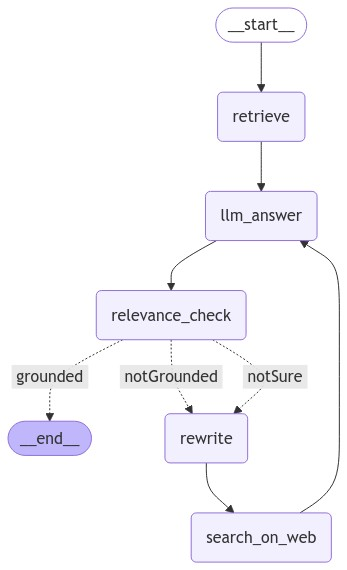

In [15]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [16]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=12, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
)

# AgentState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(
    question="제가 6개월 일하다 관뒀는데, 실업급여 대상자인지 궁금합니다."
)

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            # 출력 값을 예쁘게 출력합니다.
            pprint.pprint(value, indent=2, width=80, depth=None)
        # 각 출력 사이에 구분선을 추가합니다.
        pprint.pprint("\n---\n")
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

"Output from node 'retrieve':"
'---'
{ 'context': '<document><content>1. 근로자가 계속 근로한 기간이 3개월 미만인 경우\n'
             '2. 천재ㆍ사변, 그 밖의 부득이한 사유로 사업을 계속하는 것이 불가능한 경우\n'
             '3. 근로자가 고의로 사업에 막대한 지장을 초래하거나 재산상 손해를 끼친 경우로서 고용노동부령으로 정하는 사유\n'
             '에 해당하는 경우\n'
             '제27조(해고사유 등의 서면통지) ① 사용자는 근로자를 해고하려면 해고사유와 해고시기를 서면으로 통지하여야 한다.\n'
             '② 근로자에 대한 해고는 제1항에 따라 서면으로 통지하여야 효력이 있다.\n'
             '③ 사용자가 제26조에 따른 해고의 예고를 해고사유와 해고시기를 명시하여 서면으로 한 경우에는 제1항에 따른\n'
             '통지를 한 것으로 본다.<신설 2014. 3. 24.>\n'
             '제28조(부당해고등의 구제신청) ① 사용자가 근로자에게 부당해고등을 하면 근로자는 노동위원회에 구제를 신청할 수\n'
             '있다.\n'
             '② 제1항에 따른 구제신청은 부당해고등이 있었던 날부터 3개월 이내에 하여야 한다.\n'
             '제29조(조사 등) ① 노동위원회는 제28조에 따른 구제신청을 받으면 지체 없이 필요한 조사를 하여야 하며 관계 '
             '당사자\n'
             '를 심문하여야 한다.\n'
             '② 노동위원회는 제1항에 따라 심문을 할 때에는 관계 당사자의 신청이나 직권으로 증인을 출석하게 하여 필요한\n'
             '사항을 질문할 수 있다.\n'
             '③ 노동위원회는 제1항에 따라 심문을 할 때에는 관계 당사자에게 증거 제출과 증인에 대

In [17]:
print(output["relevance_check"]["question"])
print(output["relevance_check"]["answer"])
print(output["relevance_check"]["relevance"])

실업급여를 받기 위한 조건은 무엇이며, 6개월 근무 후 퇴사한 경우 실업급여를 받을 수 있는지에 대한 구체적인 기준이 궁금합니다.
실업급여를 받기 위한 조건은 크게 3가지입니다. 첫째, 고용보험 가입 기간이 실직 전 18개월 동안 180일 이상이어야 합니다. 둘째, 실업 사유가 적합해야 하며, 셋째, 구직 활동을 해야 합니다. 6개월 근무 후 퇴사한 경우, 만약 그 6개월이 고용보험 가입 기간에 포함된다면, 다른 근무 기간과 합산하여 180일을 채운다면 실업급여를 받을 수 있습니다. 예를 들어, A 회사에서 60일 근무하고 B 회사에서 130일 근무한 경우, 총 190일 근무한 것으로 인정되어 실업급여를 받을 수 있습니다. 

출처: [tiplab.tistory.com](https://tiplab.tistory.com/entry/실업급여), [m.blog.naver.com](https://m.blog.naver.com/meaning87/223488674570)
grounded


## LangSmith 추적

- 추적: https://smith.langchain.com/public/ce7b4ea8-df34-4bb6-850e-afc8d12e75e6/r